# Алгоритмы на основе деревьев решений

Пусть у нас задано обучающее множество пар объектов и ответов к ним $Q=\{(x, y)\}$, где $x ∈ X$ - вектора из $\mathbb{R}^M$, описываемые $M$ координатами (признаками), $y ∈ Y$ - целевая метка объекта, $|Q|=N$. Множество $Y$ может быть непрерывным (задача регрессии) с мощность $|Y|=N$ или дискретным (задача классификации) с мощностью $|Y|=K$, где $K$ - количество классов.

Наша с вами цель - составить такую функцию $f(x)$ - модель, которая наилучшим образом определяет зависимость между векторами x из множества $X$ и целевой переменной $y$ из множества $Y$   $f:X \Rightarrow Y$. 

Строго говоря, такую функцию мы будем искать не в аналитическом виде, как мы делали, например, в случае линейной регрессии, а в виде алгоритма, то есть в виде последовательности действий. Обычно в математике алгоритм обозначается как $a(x)$ или $a: X \Rightarrow Y$.


Алгоритм $a(x)$ мы будем искать в семействе деревьев решений. 

# Деревья решений. Алгоритм CART

**CART (Classification and Regression Tree)** - алгоритм и предназначенный для построения бинарных деревьев решений (деревьев, у которых каждая вершина связана с двумя другими вершинами нижнего уровня). Алгоритм очень похож на C4.5, однако в отличие от последнего предназначен как для задач классификации, так и для задач регрессии. CART важен для нас поскольку, именно он используется для построения моделей решающих деревьев в sklearn.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

# UNIT 3
### Алгоритм CART: параметры разбиения

Решаем задачу построения решающего пня: дерева с глубиной 1.

Будем рассматривать простые предикаты вида:
$$B(x_j, t)=[x_j \leqslant t]$$
Введем некоторую меру неоднородности $G(X, y, w)$, которая будет  показывать, насколько большой разброс целевой переменной $y$ для объектов из множества $X$ наблюдается в дочерних вершинах при параметрах сплита $w$. 

Параметры $w=(j, t)$ можно найти простым перебором. В качестве кандидатов на пороговое значение $t$ можно рассматривать среднее значение между двумя соседними уникальными значениями отсортированного фактора $x_j$. 

Для каждого из возможных предикатов $B(x_j, t)$ нам необходимо подсчитать значение неоднородности $G(X, y,w)$ на всей выборке и определить такую комбинацию $w_{opt}=(j_{opt}, t_{opt})$, которая дает минимум:

$$w_{opt} = argmin_w(G(X, y, w))$$

Псевдокод алгоритма поиска оптимальных параметров:
```
min_loss = inf
optimal_split_params = None
for j in range(M):
    thresholds = find_candidates_for_thresholds(X[:, j], y)
    for t in thresholds:
        split_params = (j, t)
        loss = calculate_loss(X, y, split_params)
        if loss < min_loss:
            min_loss = loss
            optimal_split_params = split_params
```

Алгоритм поиска кандидатов в параметры разбиения:
1. Сортировать числовой фактор $x_j$ по возрастанию:
$$\{x_{ij} | x_{ij}<x_{(i+1)j}\} $$
2. Вычислить среднее между двумя соседними уникальными значениями фактора:
$$\{x_{ij}^{mean}| x_{ij}^{mean}=\frac{(x_{ij}+x_{(i+1)j})}{2}\}$$
3. В качестве кандидатов на пороговые значений t выбираются только те значения, при которых целевой признак меняет свое значение.
$$\{x_{ij}^{mean}| y_i-y_{(i+1)} \neq 0\}


In [43]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']
x = x.sort_values().drop_duplicates()
x_roll_mean = x.rolling(2).mean()
x_roll_mean = x_roll_mean.dropna()
y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
candidates

2    17.5
3    19.0
7    22.5
9    30.0
4    34.5
5    43.5
Name: age, dtype: float64

In [44]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(x, data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


___
#### Самочтоятельная работа №1
#### ФУНКЦИЯ ПОИСКА КАНДИДАТА

In [45]:
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

In [46]:
x_1 = ames_sample['Lot Frontage']
y_1 = ames_sample['SalePrice']
x_1 = x_1.sort_values().drop_duplicates()
x_roll_mean = x_1.rolling(2).mean()
x_roll_mean = x_roll_mean.dropna()
y_1 = y_1[x_roll_mean.index]
y_roll_mean = y_1.diff()
candidates = x_roll_mean[y_roll_mean != 0]
candidates

8      53.0
0      58.0
14     61.0
2      65.0
9      69.0
7      71.0
5      76.0
4      86.0
1      94.0
12    101.0
Name: Lot Frontage, dtype: float64

In [47]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice']))
print(find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice']))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]
[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


___

# UNIT 4
### Алгоритм CART: неоднородность, критерии информативности

Пары объектов $x$ и ответов $y$, соответствующих им, обозначим одной буквой $Q=\{(x, y)\}$. Пусть это множество $Q$ содержит $N=|Q|$ объектов из обучающей выборки.

Введем функцию **критерия информативности (критерий неоднородности)** $H(Q)$, которая показывает разброс ответов $y$ в обучающей выборке $Q$.

Предположим, что мы выбрали какие конкретные параметры $w$, тогда множество $Q$ разбивается на две части: $Q^{left}=(X^{left} ,y^{left})$ и $Q^{right}=(X^{right} ,y^{right})$, для которых условие предиката $B(x_j,t)$ выполняется и не выполняется соответственно:
 
$$Q^{left}=\{(x, y)| x_{j} \leqslant t\}$$

$$Q^{right}=Q - Q^{left}=\{(x, y)| x_j>t\}$$
 
Каждая из полученных выборок будет иметь свои размеры - мощности множеств, назовем их как $N^{left}=|Q^{left}|$ и $N^{right}=|Q^{right}|$.
Введем понятие **взвешенной неоднородности**:
$$G(Q, w) = \frac{N^{left}}{N} H(Q^{left}) + \frac{N^{right}}{N} H(Q^{right})  \Rightarrow min_{w}$$

$$w_{opt} = argmin_w(G(Q, w))$$

Тогда **прирост информации (information gain)** будет выражаться как: 
 
$$IG(Q, w)=H(Q)-G(Q, w)=H(Q)- \frac{N^{left}}{N} H(Q^{left})-\frac{N^{right}}{N} H(Q^{right})$$

#### Критерии информативности регрессии:
* **squared error:**
$$H(Q)=\frac{1}{N} \sum_{y∈ Q} (y-\hat{y})^2 = \frac{1}{N} \sum_{y∈ Q} (y-\overline{y})^2 $$
$$\overline{y} = \frac{1}{N} \sum_{y∈ Q}y$$

* **absolute error:**
$$H(Q)=\frac{1}{N} \sum_{y∈ Q} |y-\hat{y}| = \frac{1}{N} \sum_{y∈ Q} |y-median(y)| $$

* **poisson:**

$$H(Q)=\frac{1}{N} \sum_{y∈ Q} (y log (\frac{y}{\overline{y}} - y + \overline{y}) $$

#### Критерии информативности классификации:

Вероятность принадлежности к классу под номером $k$: 
 
$$P_k=\frac{1}{N}\sum_{y∈ Q}[y=k]$$

* **entropy:**
$$H(Q)=-\sum_{k=1}^{K} P_k log(P_k)$$

* **gini:**

$$H(Q)=\sum_{k=1}^{K}P_k(1-P_k)$$

In [48]:
#Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). 
# Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

#Далее нам необходимо реализовать функцию split(), 
# которая разбивает выборку (X, y) по предикату [x_1 <= t] с параметрами разделения (split_params) на левую и правую части:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

# Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, 
# а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция squared_error()). 
# Результатом работы функции будет взвешенная неоднородность после разбиения.
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

# Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения 
# и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать 
# оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [49]:
# Создаем обучающую выборку
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 5.5


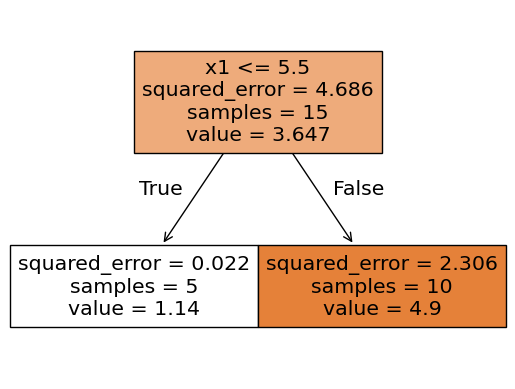

In [50]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

___
#### Самоcтоятельная работа №1
#### КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ РЕГРЕССИИ

In [51]:
# дан датасет
ames_data = pd.read_csv('data/AmesHousing.csv')
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)
X = ames_sample[["Lot Frontage"]]
y = ames_sample["SalePrice"]
display(ames_sample)

,Lot Frontage,Lot Area,SalePrice
0,60.0,11040,108000
1,96.0,10628,193000
2,68.0,9717,142125
3,50.0,9060,150909
4,92.0,9215,204500
5,80.0,10386,305900
6,60.0,7350,139000
7,72.0,8640,229800
8,56.0,6956,97900
9,70.0,12886,175000


In [52]:
# функция для определения кондидатов
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values



In [53]:
#Для начала создадим функцию для расчёта среднего квадрата ошибки — squared_error(). 
# Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

#Далее нам необходимо реализовать функцию split(), 
# которая разбивает выборку (X, y) по предикату [x_1 <= t] с параметрами разделения (split_params) на левую и правую части:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

# Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, 
# а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция squared_error()). 
# Результатом работы функции будет взвешенная неоднородность после разбиения.
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

# Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения 
# и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать 
# оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [54]:
# Находим оптимальные параметры разбиения
optimal_split_params= best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


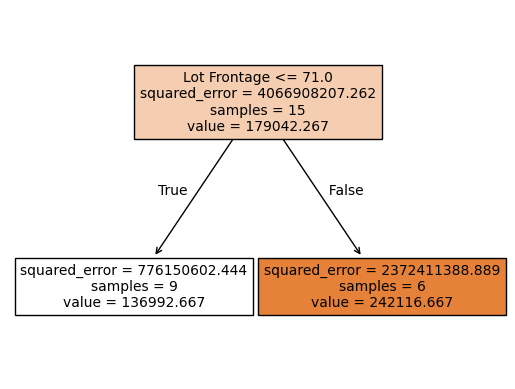

In [55]:
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

___
#### Самочтоятельная работа №2
#### КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ КЛАССИФИКАЦИИ

In [56]:
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
#X = bill_sample[['Variance']]
X = bill_sample[['Skewness']]
y = bill_sample['Class']


In [57]:
# функция для определения кондидатов
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(bill_sample['Variance'], bill_sample['Class']))
print(find_candidates_for_thresholds(bill_sample['Skewness'], bill_sample['Class']))

[-1.74515  -1.25364  -0.436945  1.236055  1.5384  ]
[-5.228     1.209485  1.98855   2.2493    3.22085 ]


In [58]:
#ДРеализуем функцию entropy(), которая рассчитывает энтропию Шеннона. На вход функции приходит целевая переменная y. 
# Далее с помощью функции value_counts() считаются доли каждого из классов — вероятности принадлежности к классам. 
# Затем эти вероятности логарифмируются по основанию 2, и наконец по приведённой выше формуле рассчитывается энтропия.
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

#Далее нам необходимо реализовать функцию split(), 
# которая разбивает выборку (X, y) по предикату [x_1 <= t] с параметрами разделения (split_params) на левую и правую части:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

# Затем создадим функцию calculate_weighted_impurity(). Она будет принимать на вход выборку — X и y, параметры разбиения — split_params, 
# а также criterion — функцию, по которой рассчитывается критерий информативности (у нас это функция entropy()). 
# Результатом работы функции будет взвешенная неоднородность после разбиения.
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

# Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения 
# и найти оптимальные из них. За данный шаг будет отвечать функция best_split(). Она будет принимать на вход выборку (X и y) и возвращать 
# оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально, а также значение этой неоднородности.
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

In [59]:
# Находим оптимальные параметры разбиения
optimal_split_params= best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 3.22085


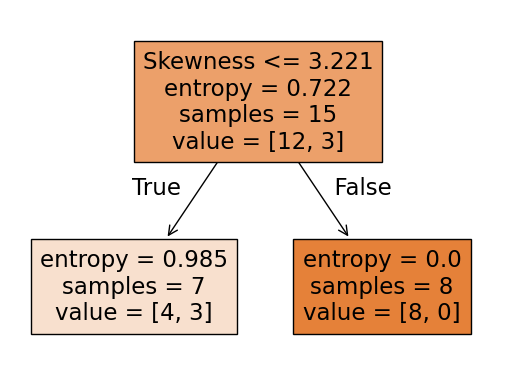

In [60]:
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

___

# UNIT 5
### Алгоритм CART: рекурсия, критерии остановки

Итак, пусть $Q_v=\{(x, y)\}$ - множество объектов и ответов к ним, попавших в вершину с номером $v$, $N_v=|Q_v|$. Пусть задан критерий информативности $H(Q)$, который зависит от задачи (регрессия - squared error, absolute error или poisson, классификация - gini или entropy).
 
А также задан некоторый критерий остановки рекурсии $stop\_criterion(Q_v)$. 

Наш алгоритм построения дерева решений CART будет выглядеть следующим образом:
1. Создаем вершину под номером $v$
2. Проверяем критерий остановки $stop\_criterion(Q_v)$ <p>
    2.1. Если условие выполнено.
    Формируем листовую вершину $v$ и ставим в соответствие этому листу ответ $\hat{y_v}$, который будет выдаваться для новых объектов, которые дойдут до этого листа. Назовем эту часть $create\_leaf()$.
    * Регрессия:
    $$\hat{y_v}=\frac{1}{N_v}\sum_{y ∈ Q_v}y$$
    $$или$$
    $$\hat{y_v}={median}_{y ∈ Q_v}(y)$$
    * Классификация:
    $$P_{vk}=\frac{1}{N_v}\sum_{y ∈ Q_v}[y=k],$$
    $$\hat{y_v}=argmax_{k∈K}(P_{vk})$$
    2.2. Если условие остановки не выполнено.
    Строим решающий пень. Формируем решающее правило $B(x_j, t)$ для вершины $v$. Из возможных комбинаций $w=(j, t)$ находим такую, которая определяет наилучшее разбиение текущего множества объектов и ответов к ним $Q_v$
    $$G(Q, w) = \frac{N_v^{left}}{N_v} H(Q_v^{left}) + \frac{N_v^{right}}{N} H(Q_v^{right})  \Rightarrow min_{w}$$
    
    $$w_{opt} = argmin_w(G(Q_v, w))$$
    
    $$B_v(x_j, t) = [x_{j_{opt}} \leqslant t_{opt}]$$
    Для выборок $Q_v^{left}$ и $Q_v^{right}$ процедура будет повторяться рекурсивно, пока не выполнится критерий остановки.
3. Возвращаем созданную вершину

In [61]:
# Для начала создадим вспомогательный класс вершины
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf
# -Если вершина является корневой или внутренней, для неё устанавливаются ссылки на потомков, параметры разбиения, неоднородность и количество объектов.
# -Если вершина является листовой, для неё указываются только ответ, неоднородность и количество объектов, а параметр is_leaf устанавливается в значение True.

# Для случая задачи классификации ответ — это класс с наибольшей вероятностью, иначе говоря, самый популярный класс. Мы знаем, 
# что самое популярное значение — это мода, а в Pandas как раз есть функция, которая позволяет вычислять её в одну строку кода, — mode(). 
# Помним, что мод может быть несколько — нам нужна любая из них, поэтому мы берём первое значение из списка.

# Реализуем эту часть в виде функции create_leaf_prediction(). Она будет принимать на вход целевую переменную y и возвращать модальное значение:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

# Далее введём критерий остановки. Самый базовый критерий — равенство нулю критерия информативности, рассчитанного по вершине.
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

#Наконец, создадим функцию build_decision_tree(). Она будет реализовывать сам рекурсивный алгоритм построения дерева решений. 
# Функция будет принимать на вход выборку X и y, а также критерий информативности. На выходе функции должна быть корневая вершина дерева 
# (объект класса Node). Она будет ссылаться на своих левого и правого потомка, они в свою очередь будут ссылаться на своих потоков, 
# и так далее до самых листьев.
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

# Также напишем вспомогательную функцию print_decision_tree(). Она будет принимать на вход корневую вершину дерева решений и 
# рекурсивно выводить дерево решений в виде текста:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


In [62]:
# Создаем модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Печатаем дерево решений в виде списка условий
print(tree.export_text(decision_tree=dt))

|--- feature_0 <= 43.50
|   |--- feature_1 <= 86.00
|   |   |--- feature_0 <= 22.50
|   |   |   |--- feature_0 <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  19.00
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  22.50
|   |   |   |--- class: 1
|   |--- feature_1 >  86.00
|   |   |--- class: 0
|--- feature_0 >  43.50
|   |--- class: 0



In [63]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)  

def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))


Predictions: [1 0 1 0 1 0 0 1 1 0]


Примечание. Для задачи регрессии в коде изменятся две вещи:

Функция create_leaf_prediction(). Вместо модального значения классов в листьях рассчитывается среднее значение целевой переменной:  
def create_leaf_prediction(y):  
   value = y.mean()  
   return value  

Функция для расчёта критерия информативности (параметр criterion). В качестве критерия можно взять, например, квадратичную ошибку:  
def squared_error(y):  
    y_pred = y.mean()  
    return ((y - y_pred) ** 2).mean()  

___
#### Самочтоятельная работа №4
#### КРИТЕРИИ ИНФОРМАТИВНОСТИ В ЗАДАЧЕ КЛАССИФИКАЦИИ (рекурсия)

In [64]:
# Для начала создадим вспомогательный класс вершины
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf
# -Если вершина является корневой или внутренней, для неё устанавливаются ссылки на потомков, параметры разбиения, неоднородность и количество объектов.
# -Если вершина является листовой, для неё указываются только ответ, неоднородность и количество объектов, а параметр is_leaf устанавливается в значение True.

# Для случая задачи классификации ответ — это класс с наибольшей вероятностью, иначе говоря, самый популярный класс. Мы знаем, 
# что самое популярное значение — это мода, а в Pandas как раз есть функция, которая позволяет вычислять её в одну строку кода, — mode(). 
# Помним, что мод может быть несколько — нам нужна любая из них, поэтому мы берём первое значение из списка.

# Реализуем эту часть в виде функции create_leaf_prediction(). Она будет принимать на вход целевую переменную y и возвращать модальное значение:
def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

# Далее введём критерий остановки. Самый базовый критерий — равенство нулю критерия информативности, рассчитанного по вершине.
def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

#Наконец, создадим функцию build_decision_tree(). Она будет реализовывать сам рекурсивный алгоритм построения дерева решений. 
# Функция будет принимать на вход выборку X и y, а также критерий информативности. На выходе функции должна быть корневая вершина дерева 
# (объект класса Node). Она будет ссылаться на своих левого и правого потомка, они в свою очередь будут ссылаться на своих потоков, 
# и так далее до самых листьев.
def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

# Также напишем вспомогательную функцию print_decision_tree(). Она будет принимать на вход корневую вершину дерева решений и 
# рекурсивно выводить дерево решений в виде текста:
def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
bill_data = pd.read_csv('data/bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance']]
# X = bill_sample[['Skewness']]
y = bill_sample['Class']

decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 1.538:
       feature_0 <= 1.236:
          feature_0 <= -0.437:
             feature_0 <= -1.254:
                class: 0
             feature_0 > -1.254:
                class: 1
          feature_0 > -0.437:
             class: 0
       feature_0 > 1.236:
          class: 1
    feature_0 > 1.538:
       class: 0


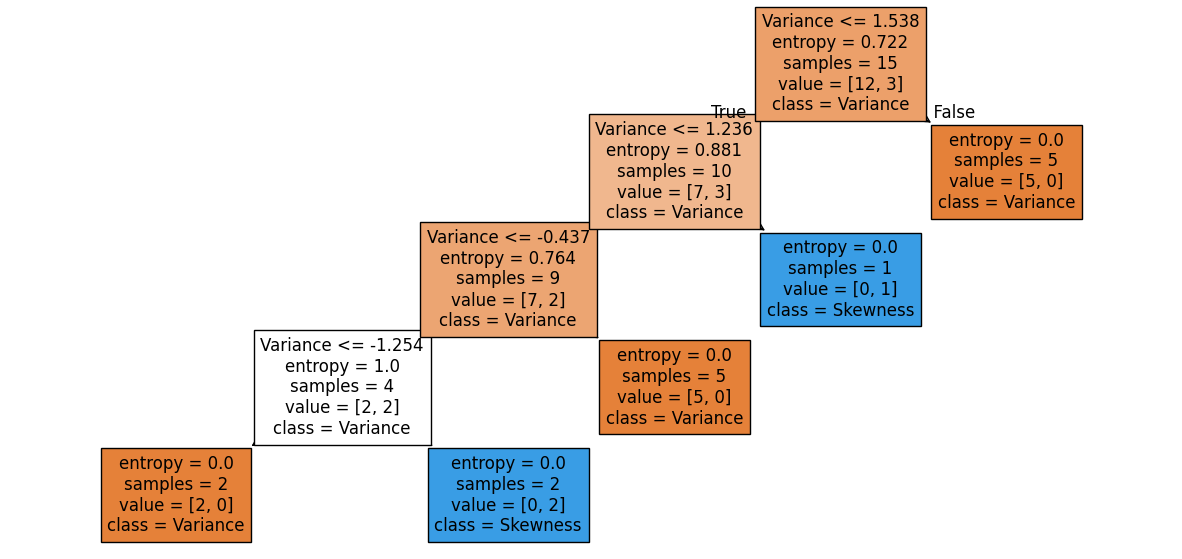

In [65]:
# Создаем модель дерева решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Печатаем дерево решений в виде списка условий
# print(tree.export_text(decision_tree=dt))


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['Variance', 'Skewness'], 
    filled=True, 
    impurity=True
);

In [66]:
def predict_sample(node, x):
    if node.is_leaf:
        return node.value
    j, t = node.split_params
    if x[j] <= t:
        return predict_sample(node.left, x)
    else:
        return predict_sample(node.right, x)  

def predict(decision_tree, X):
    predictions = [predict_sample(decision_tree, x) for x in X.values]
    return np.array(predictions)

# Предсказываем целевую переменную
y_pred = predict(decision_tree, X)
print('Predictions: {}'.format(y_pred))

Predictions: [0 0 0 0 0 0 0 0 0 0 1 1 0 1 0]


___

### Алгоритм CART: критерии остановки
В реализации дерева решений в sklearn предусмотрено несколько критериев при выполнении одного из которых ветвление дерева прекращается:
* Достижения однородности (основной критерий)
* Ограничение максимальной глубины дерева (параметр max_depth)
* Ограничение на максимальное количество листьев в дереве (параметр max_leaf_node)
* Ограничение на минимальное количество объектов, при которых допускается ветвление дерева (параметр min_samples_split)
* Ограничение на минимальное количество объектов, необходимых для создания листа (параметр min_samples_leaf)

In [67]:
# задан мини датасет
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

#### 1. ДОСТИЖЕНИЕ ОДНОРОДНОСТИ
> Критерий гласит: ветвление дерева решений прекращается, когда неоднородность вершины, определяемая критерием информативности минимальна, то есть H(Q) = 0
- Для задачи классификации это условие означает, что все объекты в вершине являются объектами одного класса.
- Для задачи регрессии это условие означает, что средняя ошибка предсказания вершины равна нулю.

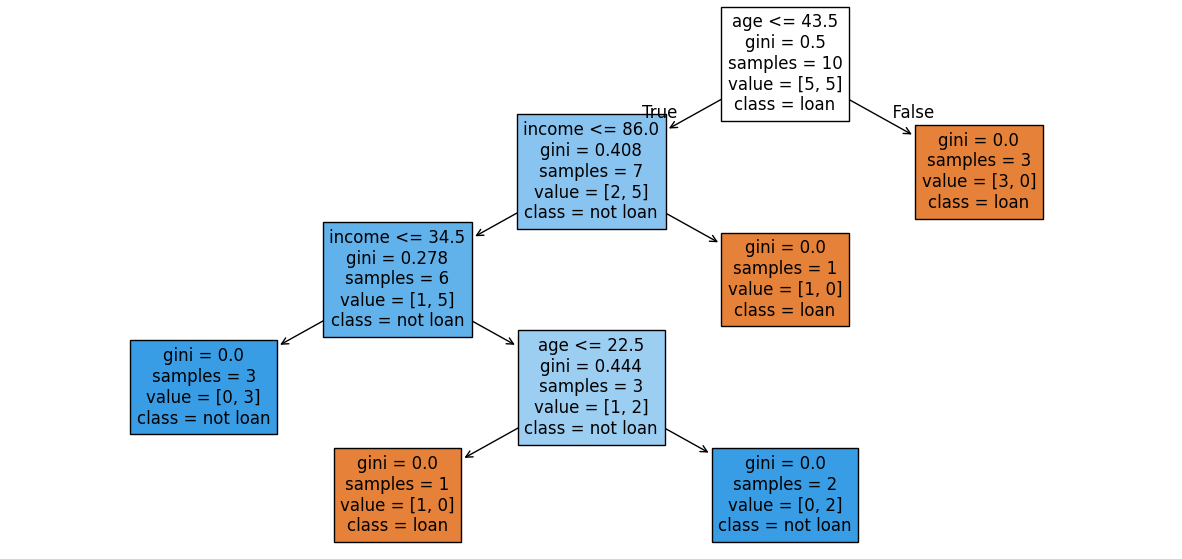

In [68]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

__ВЫВОД__ Обратите внимание, что во всех листовых вершинах (мы выделили их красным) неоднородность, обозначенная как gini, равна 0, а в самих листьях содержатся объекты (value) только одного определённого класса.
___

#### 2. Ограничение максимальной глубины дерева (параметр max_depth)
> Идея состоит в том, что, когда дерево достигает максимально заданной глубины, ветвление прекращается. С точки зрения программной реализации, это означает ограничение глубины рекурсии.
- По умолчанию глубина дерева не ограничена. Помните, что ограничение глубины дерева решений является основным методом борьбы с его переобучением.`

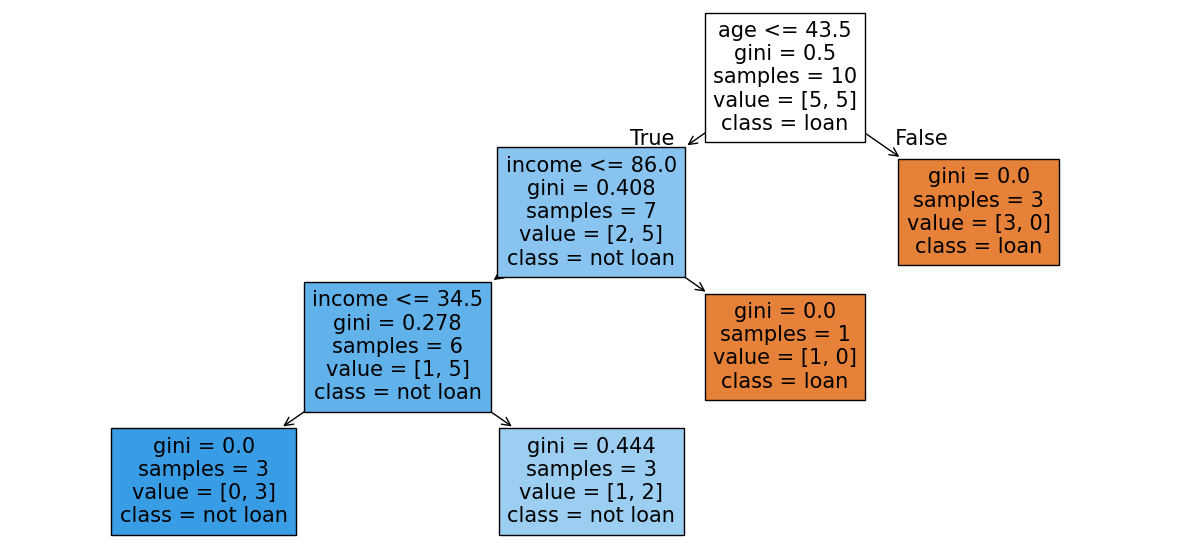

In [69]:
# ограничим глубину нашего дерева решений до 3:
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

___

#### 3. Ограничение максимального количества листьев в дереве (параметр max_leaf_node)
>Здесь всё происходит по аналогии с максимальной глубиной дерева: мы задаём максимальное количество листьев, которое может быть в дереве — когда количество листьев в дереве достигает этой верхней планки, ветвление прекращается.
- По умолчанию количество листьев не ограничено. Как и все критерии остановки, ограничение на количество листьев может служить инструментом борьбы с переобучением дерева.

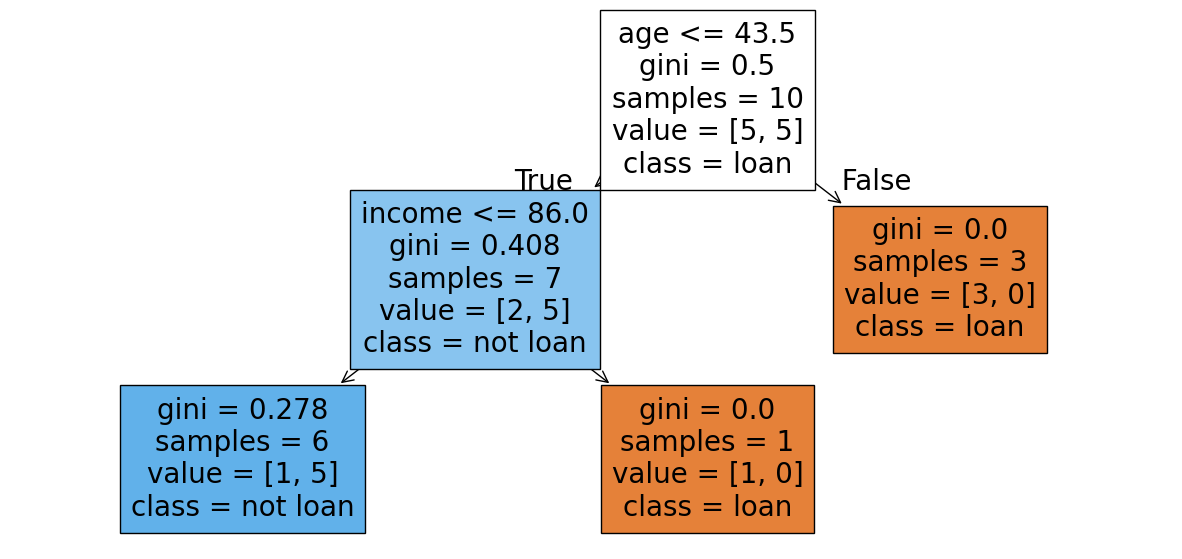

In [70]:
# ограничим количество листьев в нашем дереве до 3:
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

__ВЫВОД__ Видим, что из-за ограничения на количество листьев в дереве разделения по предикату $ income\le34.5$ не произошло — вместо этого данная вершина превратилась в листовую, и итоговая глубина дерева уменьшилось с 4 до 3. Общее количество листьев в дереве, как мы и указывали, равно 3.
___

#### 4. Ограничение на минимальное количество объектов, при которых допускается ветвление дерева (параметр min_samples_split)
> Идея ограничения проста, как и все предыдущие. Пусть в вершину попала выборка Q_v, количество объектов в этой вершине — N_v = 5. При этом однородность в этой вершине не равна 0.
- По идее, ветвление дерева должно быть продолжено. Однако если мы установим ограничение на минимальное количество объектов для разделения (min_samples_split = 6), то разделения вершины не произойдёт.

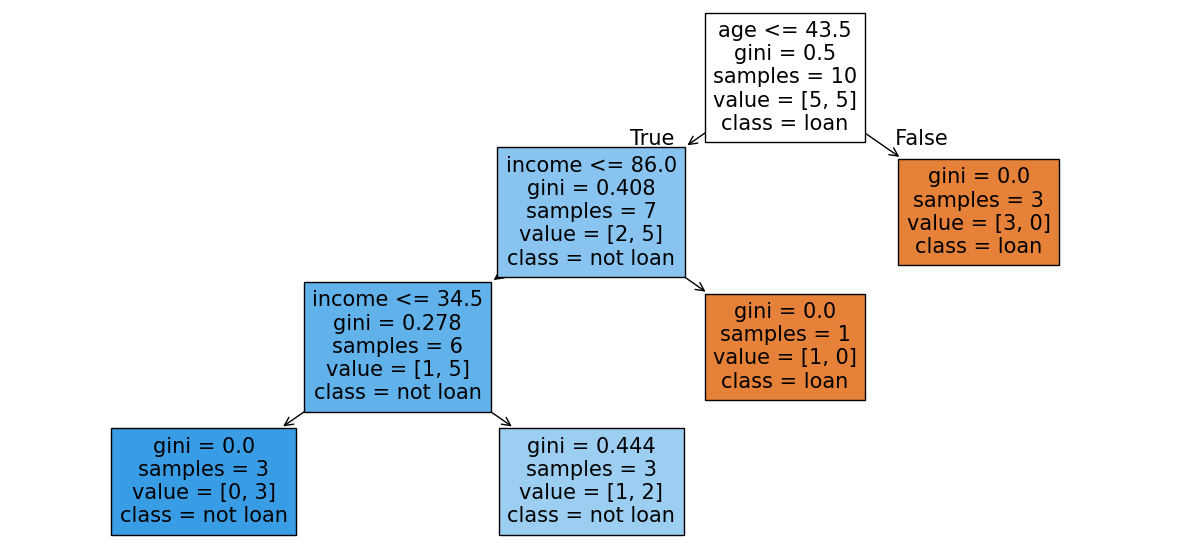

In [71]:
dt = tree.DecisionTreeClassifier(
    min_samples_split=6, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

__ВЫВОД__ Видим, что разделение по условию $income \le 34.5$ произошло, так как количество объектов в вершине (samples), соответствующей ему, равно 6. А вот в вершинах, где количество наблюдений равно 3, разделения не произошло. 

#### 5. Ограничение на минимальное количество объектов, необходимых для создания листа (параметр min_samples_leaf)
Предположим, что при разделении выборки $Q_v$ на $Q_v^{left}$ и $Q_v^{right}$ с параметрами разделения w случилось так, что и в левую вершину попало $Q_v^{left} = 3$ наблюдения, а в правую — $Q_v^{right} = 2$, причём взвешенная неоднородность в правой части — $G(Q_v^{right}, w) \ne 0$. При этом мы поставили ограничение min_samples_leaf=3.  

В таком случае, даже несмотря на неравенство нулю неоднородности в правой вершине, ветвления не произойдёт, так как минимальное количество объектов, которое допускается в листовой вершине, — 3. Это значит, что разделение вершины на две новых при таких параметрах разделения не будет произведено.

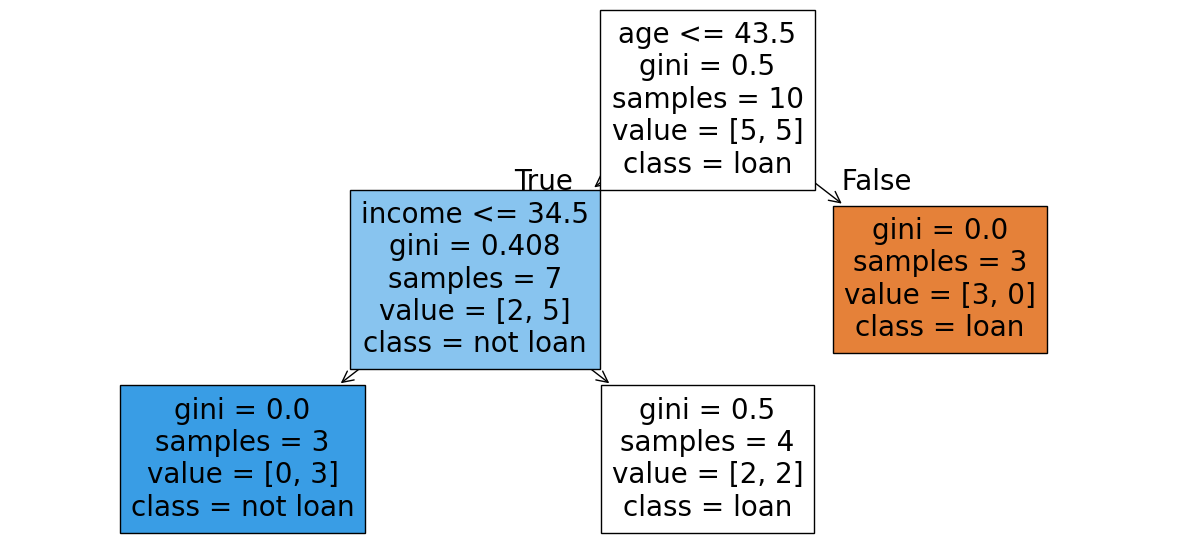

In [72]:
dt = tree.DecisionTreeClassifier(
    min_samples_leaf=3, 
    random_state=42
)
dt.fit(X, y)


fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=X.columns, 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

__ВЫВОД__ Обратите внимание, что в выделенной красным вершине ранее находилось условие $income \le 86$, а теперь там находится условие $income \le 34.5$. Как это произошло?

На самом деле всё просто. При разделении по решающему правилу $income \le 86$ у нас бы получались две новых вершины: в левой находилось бы шесть объектов, а в правой — один, причём правая вершина стала бы листовой. Однако у нас стоит ограничение: количество объектов в листовых вершин должно быть не менее 3. Поэтому такое разделение нам не подходит. Под данное условие подходит только одно решающее правило — $income \le 34.5$. При таком разделении в левую вершину попадает три объекта, а в правую — четыре. После этого ветвление прекращается.

### Функция дерева решения + критерии остановки

In [73]:
#Давайте адаптируем наш метод построения дерева решений и введём новое ограничение на максимальную глубину дерева: в функции stop_criterion() и 
# build_decision_tree() добавим параметр max_depth, а также счётчик глубины рекурсии depth:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_rigth, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

# Строим дерево решений с ограничением глубины и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=3)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             class: 1
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


# Unit 6
### Алгоритм CART: значимость признаков

Прирост информации: 
$$IG(Q_v, w)=H(Q_v)-G(Q_v, w)=H(Q_v)- \frac{N_v^{left}}{N_v} H(Q_v^{left})-\frac{N_v^{right}}{N_v} H(Q_v^{right})$$
или:
$$IG(Q_v, w)= {N_v} H(Q_v) - {N_v^{left}} H(Q_v^{left})- {N_v^{right}} H(Q_v^{right})$$

Тогда значимость **(абсолютная)** признаков будет определяться как:
$$F(x_j)=\frac{1}{N} \sum_{v ∈ V_j}IG(Q_v, w)$$

Нормируем полученные соотношения и получим **относительную** значимость:
$$\overline{F(x_j)}=\frac{F(x_j)}{\sum_{j =1}^M F(x_j)}$$

In [74]:
def calculate_feature_importances(node, feature_importance=None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if node.value is None:
        j = node.split_params[0]
        feature_importance[j] += node.impurity * node.samples - \
                                 node.left.impurity * node.left.samples - \
                                 node.right.impurity * node.right.samples
        calculate_feature_importances(node.left, feature_importance)
        calculate_feature_importances(node.right, feature_importance)
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    return feature_importance

# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Считаем информативности признаков
print(calculate_feature_importances(decision_tree))

[0.78582905 0.21417095]


In [75]:
# Создаём модель дерева решений и обучаем её
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=1000 #генератор случайных чисел
)
dt.fit(X, y)
# Вычисляем значения информативности признаков
print(dt.feature_importances_)
# [0.78582905 0.21417095]

[0.78582905 0.21417095]
